<center>
<h1>Fake news detection using graph neural network</h1>
<h2>Basic GNN</h2>
<i><h6>Victor GOUBET | Nicholas Tagliapietra | Asma Bakhtiariazad</h6></i>
</center>


----

# Library

In [1]:
import torch
import pickle as pk

from torch.nn import Linear, LogSoftmax
from tool_box.upfd_dataset import ext_UPFD
from tool_box.GNN_train import plot_hist, train_all_and_optimize
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool

# Import datasets

In [2]:
datasets = pk.load(open('../data/datasets.pkl', 'rb'))

# Define the model

In [3]:
class Basic_GNN(torch.nn.Module):

    def __init__(self, num_n_feature, num_g_feature, emb_size):
        super(Basic_GNN, self).__init__()
        torch.manual_seed(42)
        self.emb_size = emb_size

        self.in_layer = GCNConv(num_n_feature, emb_size)
        self.conv = GCNConv(emb_size, emb_size)
       
       # check if we have graph features to concatenate or not
        i = 2
        if num_g_feature:
             self.lin_g = Linear(num_g_feature, emb_size)
             i = 3

        self.out_layer = Linear(i * emb_size, 2)
        self.act = LogSoftmax(dim=-1)
    
    def forward(self, x, edges_idx, batch_idx, g_features):
        
        x = self.in_layer(x, edges_idx)
        
        x = self.conv(x, edges_idx)

        flatten = torch.cat([global_mean_pool(x, batch_idx),
                             global_max_pool(x, batch_idx)], axis=1)

        if g_features.size()[-1] > 1:
            g_ft = self.lin_g(g_features)
            flatten = torch.cat([flatten, g_ft], axis=1)

        out = self.act(self.out_layer(flatten))

        return out


# Training

In [4]:
models = train_all_and_optimize(Basic_GNN, datasets, epochs = 60)

[I 2022-01-07 10:56:48,934] A new study created in memory with name: no-name-50063010-db2f-4989-92df-9b9554fc777d


--> Train on: origin


[I 2022-01-07 10:57:16,405] Trial 0 finished with value: 0.9015778186274509 and parameters: {'learning_rate': 0.01, 'weight_decay': 0.01, 'batch_size': 256, 'embedding_space_dim': 140}. Best is trial 0 with value: 0.9015778186274509.
[I 2022-01-07 10:57:34,799] Trial 1 finished with value: 0.9237898284313726 and parameters: {'learning_rate': 0.01, 'weight_decay': 0.005, 'batch_size': 256, 'embedding_space_dim': 140}. Best is trial 1 with value: 0.9237898284313726.
[I 2022-01-07 10:57:50,883] Trial 2 finished with value: 0.9042279411764707 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.005, 'batch_size': 128, 'embedding_space_dim': 80}. Best is trial 1 with value: 0.9237898284313726.
[I 2022-01-07 10:58:11,073] Trial 3 finished with value: 0.9163602941176471 and parameters: {'learning_rate': 0.01, 'weight_decay': 0.005, 'batch_size': 128, 'embedding_space_dim': 140}. Best is trial 1 with value: 0.9237898284313726.
[I 2022-01-07 10:58:27,069] Trial 4 finished with value: 0.90

  0%|          | 0/60 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.21936904191970824  loss_val=0.23689858615398407 | acc_train=0.9124540441176471  acc_val=0.9034926470588235
Epochs: 20 | loss_train=0.2030905306339264  loss_val=0.19685549040635428 | acc_train=0.9177389705882353  acc_val=0.9119944852941176
Epochs: 30 | loss_train=0.21246609091758728  loss_val=0.1973064293464025 | acc_train=0.9194852941176471  acc_val=0.9355085784313726
Epochs: 40 | loss_train=0.24855241775512696  loss_val=0.2591916124025981 | acc_train=0.8948069852941176  acc_val=0.9074754901960785
Epochs: 50 | loss_train=0.20903334617614747  loss_val=0.20021887123584747 | acc_train=0.9161305147058825  acc_val=0.9270067401960785
Epochs: 60 | loss_train=0.20861663520336152  loss_val=0.19395631303389868 | acc_train=0.9176930147058824  acc_val=0.9453125


[I 2022-01-07 10:59:57,774] A new study created in memory with name: no-name-ff606918-3322-48e0-8adb-3b0a2dbae6ec


--> Train on: dataset1


[I 2022-01-07 11:00:19,980] Trial 0 finished with value: 0.8932904411764706 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.001, 'batch_size': 128, 'embedding_space_dim': 160}. Best is trial 0 with value: 0.8932904411764706.
[I 2022-01-07 11:00:37,739] Trial 1 finished with value: 0.9325022977941176 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.001, 'batch_size': 512, 'embedding_space_dim': 140}. Best is trial 1 with value: 0.9325022977941176.
[I 2022-01-07 11:00:53,056] Trial 2 finished with value: 0.8501072303921569 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.005, 'batch_size': 256, 'embedding_space_dim': 100}. Best is trial 1 with value: 0.9325022977941176.
[I 2022-01-07 11:01:12,190] Trial 3 finished with value: 0.9288602941176471 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'embedding_space_dim': 120}. Best is trial 1 with value: 0.9325022977941176.
[I 2022-01-07 11:01:33,870] Trial 4 finished with value:

  0%|          | 0/60 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.47748570640881854  loss_val=0.4586813747882843 | acc_train=0.8438265931372548  acc_val=0.8473115808823529
Epochs: 20 | loss_train=0.2986293782790502  loss_val=0.3783560246229172 | acc_train=0.8843443627450981  acc_val=0.8601217830882353
Epochs: 30 | loss_train=0.29466033975283307  loss_val=0.31384600698947906 | acc_train=0.8771063112745098  acc_val=0.8875229779411764
Epochs: 40 | loss_train=0.2213340699672699  loss_val=0.2845517247915268 | acc_train=0.9009267769607843  acc_val=0.8609834558823529
Epochs: 50 | loss_train=0.19042450686295828  loss_val=0.1825997643172741 | acc_train=0.9420189950980392  acc_val=0.9246897977941176
Epochs: 60 | loss_train=0.1870743731657664  loss_val=0.241621196269989 | acc_train=0.9390318627450981  acc_val=0.9325022977941176


[I 2022-01-07 11:02:44,767] A new study created in memory with name: no-name-41cc1fc3-3986-4b29-b67b-e4a22eb1b3f2


--> Train on: dataset2


[I 2022-01-07 11:03:04,690] Trial 0 finished with value: 0.8677236519607843 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.01, 'batch_size': 256, 'embedding_space_dim': 160}. Best is trial 0 with value: 0.8677236519607843.
[I 2022-01-07 11:03:19,543] Trial 1 finished with value: 0.8139935661764706 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.005, 'batch_size': 512, 'embedding_space_dim': 100}. Best is trial 0 with value: 0.8677236519607843.
[I 2022-01-07 11:03:34,322] Trial 2 finished with value: 0.9050436580882353 and parameters: {'learning_rate': 0.01, 'weight_decay': 0.001, 'batch_size': 512, 'embedding_space_dim': 100}. Best is trial 2 with value: 0.9050436580882353.
[I 2022-01-07 11:03:45,625] Trial 3 finished with value: 0.8532284007352942 and parameters: {'learning_rate': 0.01, 'weight_decay': 0.005, 'batch_size': 512, 'embedding_space_dim': 60}. Best is trial 2 with value: 0.9050436580882353.
[I 2022-01-07 11:03:57,485] Trial 4 finished with value: 0.8

  0%|          | 0/60 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.43712933858235675  loss_val=0.5549401491880417 | acc_train=0.8425245098039215  acc_val=0.7954388786764706
Epochs: 20 | loss_train=0.2757057100534439  loss_val=0.4364253431558609 | acc_train=0.8963694852941176  acc_val=0.8296760110294117
Epochs: 30 | loss_train=0.19952362279097238  loss_val=0.2753439098596573 | acc_train=0.9221430759803922  acc_val=0.8913717830882353
Epochs: 40 | loss_train=0.18426033357779184  loss_val=0.1709257774055004 | acc_train=0.9267003676470589  acc_val=0.9295726102941176
Epochs: 50 | loss_train=0.16569222509860992  loss_val=0.1737440526485443 | acc_train=0.9462699142156863  acc_val=0.9393956801470589
Epochs: 60 | loss_train=0.17787545919418335  loss_val=0.22532348334789276 | acc_train=0.9377680759803922  acc_val=0.9197495404411764


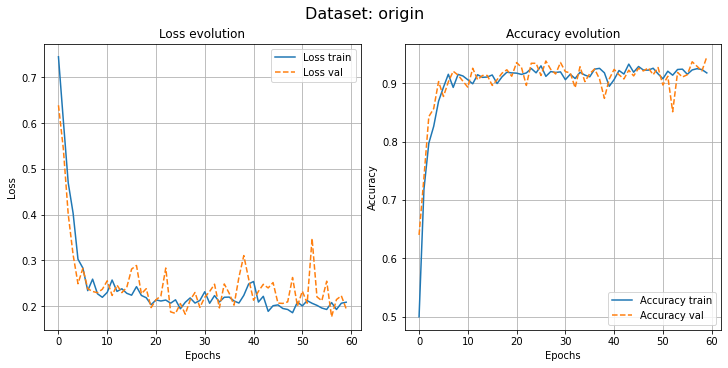

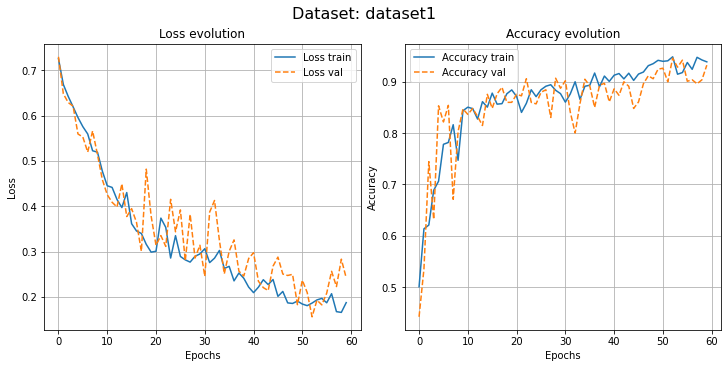

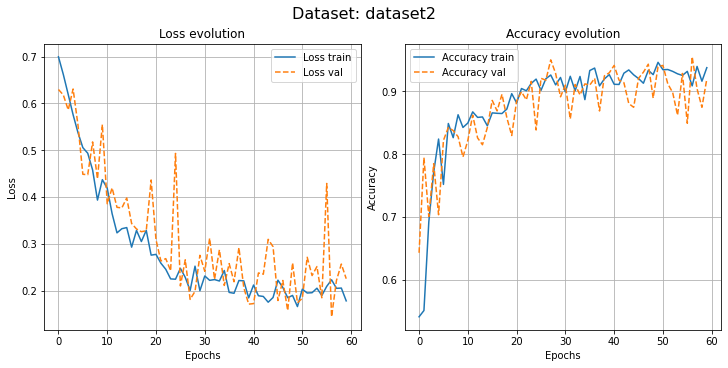

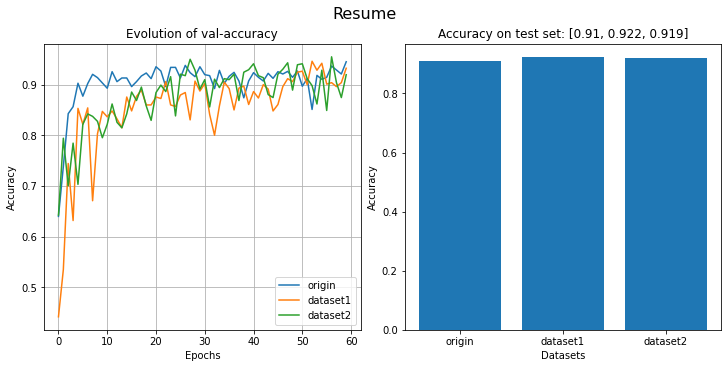

In [5]:
plot_hist(models)

# Save the three models

In [6]:
path = '../models/Basic_GNN/'
for name, model, _, _ in models:
    torch.save(model, f'{path}Basic_GNN_{name}')